In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gb
import os
from pickle import dump, load
from time import process_time
from copy import deepcopy
from source import *

path = os.getcwd()

In [2]:
file = open(path+"/Results/Configurations/Open Stations/open_stations_18","rb"); S = load(file); file.close()
K_s = {}                # {scenario:{station:[vehicles]}}n",
K = {}                  # {scenario:[vehicles]}n",

for sc in range(25):
    file = open(path+f"/Data/K/K_sc{sc}", "rb")
    K[sc] = load(file); file.close()

    file = open(path+f"/Data/K_s10/Ks_sc{sc}", "rb")
    K_s[sc] = load(file); file.close()

original_stress = {}
for s in S:
    original_stress[s] = np.mean(np.array([len(K_s[sc][s]) for sc in range(25)]))

max_s = max(original_stress, key=original_stress.get)
max_s, original_stress[max_s]

(379, 196.12)

# Give chargers to stations given their stress index (individually)

In [3]:
def generate_routes_given_number_chargers_individual(s,S,y,K,K_s_prime,exhaust=False):

    total_serviced_costumers:dict[list[list]] = dict()
    
    for sc in range(25):
        routes = list()
        K, _, S_k, a, t = load_pickle(path+"/Data/",sc)
        K_s = K_s_prime[sc]

        S_k = {k:[ss for ss in S_k[k] if ss in S] for k in K_s[s]}
        a.update({("s",s):0}); a.update({("e",s):40})
        t.update({("s",s):0}); t.update({("e",s):0})
    
        mp = gb.Model("Restricted Master Problem")
    
        dummy_0 = {k:mp.addVar(vtype=gb.GRB.CONTINUOUS, obj=1, name=f"st0_{k}") for k in K_s[s]}
        aux = mp.addVar(vtype=gb.GRB.CONTINUOUS, obj=2, name=f"aux_{s}")
    
        vehic_assign = {}
        for k in K_s[s]:
            vehic_assign[k] = mp.addLConstr(dummy_0[k] == 1, name=f"V{k}_assignment")
    
        st_conv = mp.addConstr(aux <= y, f"S{s}_convexity")
    
        mp.setParam("OutputFlag",0)
    
        time0 = process_time(); i = 0
        lbd = []; lastMP = 1e3
    
        while True:
            
            mp.update()
            mp.optimize()
    
            pi = {k:vehic_assign[k].getAttr("Pi") for k in K_s[s]}
            sigma = st_conv.getAttr("Pi")
            thisMP = mp.getObjective().getValue()
    
            if (lastMP-thisMP < 0.1 and thisMP > 5) or (lastMP-thisMP < 0.01 and thisMP<=5):
                #if y == 8: print(f"ttOut of Labeling scenario {sc}")
                mpsol = thisMP; break
    
            #print(f"tIteration {i}:ttMP obj: {round(mp.getObjective().getValue(),2)}ttime: {round(process_time()-time0,2)}s")
            i += 1
    
            V,A,rc = get_graph_chargers(s,K_s[s],a,pi,sigma)
            ext = vertices_extensions(V,A)
            
            #if y == 8:
            #    print(f"ttIteration {i}. Labeling for scenario {sc}")
    
            routes_DFS = {"s":([0],0)}; covered_nodes = {v:0 for v in V}; best_len = {v:0 for v in V}; best_t = {v:0 for v in V}; best_h = {v:30 for v in V}; num_improv = {v:0 for v in V}; tried = {v:0 for v in V}
            marked = {}; max_successors = {v:100 for v in V}
            mod_label_DFS(v="s",rP=0,tP=0,qP=0,hP=0,P=[],cK=covered_nodes,L=routes_DFS,s=s,r=rc,t=t,a=a,ext=ext,best_len=best_len,best_t=best_t,best_h=best_h,tried=tried,marked=marked,num_improv=num_improv,max_successors=max_successors)
            del routes_DFS["s"]
            
            opt = 0
            for l in routes_DFS:
                if routes_DFS[l][1] < -0.001:
                    col = {k:1 if k in routes_DFS[l][0] else 0 for k in K_s[s]}
                    new_Col = gb.Column(col.values(),vehic_assign.values())
                    lbd.append(mp.addVar(vtype=gb.GRB.CONTINUOUS,obj=0,column=new_Col))
    
                    mp.chgCoeff(st_conv,lbd[-1],1)
                    opt +=1
            if i == 1:
                original_routes = routes_DFS
    
            if opt == 0 : mpsol = thisMP; break
            lastMP = thisMP
        
        for v in mp.getVars():
            v.vtype = gb.GRB.BINARY
        #if mpsol < len(K_s[s]): mp.setParam("MIPGap",0.01)
        mp.setParam("MIPFocus",2)
        mp.update(); mp.optimize()
    
        print(f"ttSolved IMP scenario {sc}, with {mp.getObjective().getValue()} unnasigned vehicles")
        # print(f"IMP solution: {mp.getObjective().getValue()} assigned vehicles with {y} chargers")
        for l in lbd:
            if l.X > 0.5:
                col = [k for k in K_s[s] if mp.getCoeff(vehic_assign[k],l) == 1]
                routes.append(col)
    
        total_serviced_costumers[sc]:list = list()
    
        for route in routes:
            total_serviced_costumers[sc].extend(route)
        
        if len(total_serviced_costumers[sc]) < len(K_s_prime[sc][s]) and y < 8:
            print(f't{y} number of chargers is infeasiblen')
            return None, None
    
    return routes, total_serviced_costumers

In [ ]:
ordered_stations:list = sorted(original_stress, key = original_stress.get, reverse = True)     # Get list of stations ordered by stress
number_of_chargers:dict = dict()
stress = deepcopy(original_stress)

K_prime = deepcopy(K)
K_s_prime = deepcopy(K_s) 

cont:int = 0

while True:
    cont += 1 
    s = ordered_stations[0]
    
    print(f'--------- Station {s} - {stress[s]} - {original_stress[s]} ---------')
    y:int = 1       # Start giving one charger to the station

    # Iterative process to find number of chargers 
    while True:
        print(f"\tTrying for {y} chargers for station {s}")
        total_serviced_costumers:dict[list[list]] or None = generate_routes_given_number_chargers_individual(s, S, y, K_prime, K_s_prime, False)     # Get the routes for the stations
        
        if total_serviced_costumers == None:  # Station doesn't service all possible costumers in at least one scenario
            y += 1
        else:               # Number of chargers is fixed
            break
    
    # Set number of chargers and remove already serviced vehicles
    number_of_chargers[s] = y
    print(f'\n\tStation {s} set to {number_of_chargers[s]} chargers\nn----------------------------')

    
    for u in range(25):
        for vehicle in total_serviced_costumers[u]:
            K_prime[u].remove(vehicle)
        
            for ss in S:
                if vehicle in K_s_prime[u][ss]:
                    K_s_prime[u][ss].remove(vehicle)

    S.remove(s)
    stress:dict = {}
    for s in S:
        stress[s] = np.mean(np.array([len(K_s_prime[sc][s]) for sc in range(25)]))    
    ordered_stations:list = sorted(stress, key = stress.get, reverse = True)     # Get list of stations ordered by stress

    if cont == 600 or sum(len(K_s_prime[sc][s]) for sc in range(25) for s in S)==0:
        break

# Give chargers to stations given their dual variables (cluster)

In [4]:
def compute_shared_vehicles(S, K_s): 
    shared_vehicles = dict()
    for s in S:
        for ss in S:
            if s != ss:
                shared_vehicles[s,ss] = sum(len(set(K_s[sc][s]).intersection(set(K_s[sc][ss]))) for sc in range(25))/25
                # shared_vehicles[s,ss] = sum([1 for sc in range(25) for k in K_s[sc][s] if k in K_s[sc][ss]])/25
    return shared_vehicles


def get_associated_stations(S, K_s, station):
    # Get average number of shared vehicle per station
    shared_vehicles = compute_shared_vehicles(S, K_s)

    # Filter the dictionary to get the key-value pairs with matching i
    filtered_dict = {key: value for key, value in shared_vehicles.items() if key[0] == station}
    
    # Sort the filtered dictionary by values in descending order
    sorted_dict = sorted(filtered_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Extract the top four j values from the sorted dictionary
    top_j_values = [key[1] for key, value in sorted_dict[:4]]

    # Locate vehicles assigned to the stations
    K = dict()
    for sc in range(25):
        K[sc] = list()
        for s in [station]+top_j_values:
            for k in K_s[sc][s]:
                if k not in K[sc]:
                    K[sc].append(k)

    return shared_vehicles, top_j_values, K


def generate_routes_given_number_chargers(S,y,K_prime,K_s_prime,exhaust=False):

    total_serviced_costumers:dict[dict[list]] = dict()

    sigmass = dict()
    sigmass.update({s:0 for s in S})

    missing = False
    
    for sc in range(25):
        routes = list()
        _, _, S_k, a, t = load_pickle(path+"/Data/",sc)
        for s in S:
            a.update({("s",s):0}); a.update({("e",s):40})
            t.update({("s",s):0}); t.update({("e",s):0})

        K = K_prime[sc]
        K_s = K_s_prime[sc]
    
        routes, sigmas = second_stage_chargers(S, K, K_s, y, a, t)
        sigmass[s] += sigmas[s]/25

        total_serviced_costumers[sc]:dict = dict()
        total_total:list = list()
        for s in S:
            total_serviced_costumers[sc][s]:list = list()
            for route in routes[s]:
                total_serviced_costumers[sc][s].extend(route)
                total_total.extend(route)

        # for s in S:
        #     for k in K_s_prime[sc][s]:
        #         if k not in total_total and y[s] < 8:
        #             missing = True
        #             sigmass = sigmas
        #             break
        #     if missing:
        #         break
            
        # if missing:
        #     break
        
    return routes, total_serviced_costumers, sigmass, missing

In [4]:
ordered_stations:list = sorted(original_stress, key = original_stress.get, reverse = True)     # Get list of stations ordered by stress
number_of_chargers:dict = dict()
stress = deepcopy(original_stress)

K_prime = deepcopy(K)
K_s_prime = deepcopy(K_s) 

cont:int = 0

while True:
    cont += 1
    s = ordered_stations[0]
    shared_vehicles, compatible_stations, K_prime = get_associated_stations(S, K_s_prime, s)
    print(f'Cluster # {cont}: {compatible_stations}') 
    
    y:dict = {st:1 for st in compatible_stations}       # Start giving one charger to the station

    # Iterative process to find number of chargers 
    while True:
        print(f"\tTrying for {list(y.values())} configuration")
        total_serviced_costumers, sigmas, missing = generate_routes_given_number_chargers(compatible_stations, y, K_prime, K_s_prime, False)     # Get the routes for the stations
        
        if missing:
            sigmas = {key:value for key,value in sigmas.items() if y[key]<8}
            best_station = min(sigmas, key = sigmas.get)
            y[best_station] += 1
        else:
            break
    
    # Set number of chargers and remove already serviced vehicles
    for st in compatible_stations:
        number_of_chargers[st] = y[st]
        print(f'\n\tStation {st} set to {number_of_chargers[st]} chargers\nn----------------------------')

        for u in range(25):
            for vehicle in total_serviced_costumers[u][st]:
                K_prime[u].remove(vehicle)
            
                for ss in S:
                    if vehicle in K_s_prime[u][ss]:
                        K_s_prime[u][ss].remove(vehicle)

        S.remove(st)

    stress:dict = {}
    for s in S:
        stress[s] = np.mean(np.array([len(K_s_prime[sc][s]) for sc in range(25)]))    
    ordered_stations:list = sorted(stress, key = stress.get, reverse = True)     # Get list of stations ordered by stress

    if cont == 600 or sum(len(K_prime[sc]) for sc in range(25))==0:
        break

Cluster # 1: [318, 289, 101, 309]
	Trying for dict_values([1, 1, 1, 1]) chargers
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-11
	Trying for dict_values([1, 1, 1, 2]) chargers
	Trying for dict_values([2, 1, 1, 2]) chargers
	Trying for dict_values([3, 1, 1, 2]) chargers
	Trying for dict_values([3, 1, 1, 3]) chargers
	Trying for dict_values([4, 1, 1, 3]) chargers
	Trying for dict_values([4, 2, 1, 3]) chargers
	Trying for dict_values([5, 2, 1, 3]) chargers
	Trying for dict_values([5, 2, 2, 3]) chargers
	Trying for dict_values([5, 2, 2, 4]) chargers
	Trying for dict_values([6, 2, 2, 4]) chargers
	Trying for dict_values([7, 2, 2, 4]) chargers
	Trying for dict_values([8, 2, 2, 4]) chargers
	Trying for dict_values([8, 2, 2, 5]) chargers
	Trying for dict_values([8, 2, 2, 6]) chargers
	Trying for dict_values([8, 2, 3, 6]) chargers
	Trying for dict_values([8, 2, 3, 7]) chargers
	Trying for dict_values([8, 3, 3, 7]) chargers
	Trying for dict_values([8, 3

# Two phase assignment: Give one charger to each station and then assing given their stress index

In [5]:
start = process_time()

# Duplicate parameters
K_prime = deepcopy(K)
K_s_prime = deepcopy(K_s) 
ordered_stations:list = sorted(original_stress, key = original_stress.get, reverse = True)     # Get list of stations ordered by stress

# Give one charger to each station
y:dict = dict(); y.update({s:1 for s in S})

# Generate initial routes (one charger per station)
routes, total_serviced_costumers, sigmas, missing = generate_routes_given_number_chargers(S, y, K_prime, K_s_prime, False)     # Get the routes for the stations
print(f'\n\t--------- Finished initial assignment at {round(process_time()-start,s)} --------- \n')

# Fix serviced vehicles per each station
for s in ordered_stations:
    for sc in range(25):
        for vehicle in total_serviced_costumers[u][sc]:
            K_prime[sc].remove(vehicle)
        
            for ss in S:
                if vehicle in K_s_prime[sc][ss]:
                    K_s_prime[sc][ss].remove(vehicle)

# If a station no longer has availabe vehicles on any scenario, remove. Else, compute new stress index
stress:dict = dict()
for s in S:
    if sum(len(K_s_prime[sc][s]) for sc in range(25))==0:
        S.remove(s)
    else:
        stress[s] = np.mean(np.array([len(K_s_prime[sc][s]) for sc in range(25)]))    

ordered_stations:list = sorted(stress, key = stress.get, reverse = True)     # Get list of stations ordered by stress

# Iterative process
cont:int = 600-len(S)
while True:
    cont += 1
    s = ordered_stations[0]

    # Iterative process to find number of chargers 
    while True:
        routes, total_serviced_costumers = generate_routes_given_number_chargers_individual(s, S, y[s], K_prime, K_s_prime, False)     # Get the routes for the stations
        
        if routes == None:
            y[s] += 1
        else: 
            break
            
    print(f'\n\t--------- Station {s} set to {y[s]} chargers --------- \n')    

    # Save routes and remove serviced vehicles
    routes[s].extend(routes)
    for u in range(25):
        for vehicle in total_serviced_costumers[u]:
            K_prime[u].remove(vehicle)
        
            for ss in S:
                if vehicle in K_s_prime[u][ss]:
                    K_s_prime[u][ss].remove(vehicle)

    S.remove(s)

    # Recompute stress index
    stress:dict = dict()
    for s in S:
        stress[s] = np.mean(np.array([len(K_s_prime[sc][s]) for sc in range(25)]))    
    ordered_stations:list = sorted(stress, key = stress.get, reverse = True)     # Get list of stations ordered by stress

    if cont == 600 or sum(len(K_s_prime[sc][s]) for sc in range(25) for s in S)==0:
        break

a_file = open(path, "wb")
pickle.dump(y, routes)
a_file.close()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-11


In [ ]:
################# FUTURE WORK #######################
'''Assign chargers to most average negative dual variable station'''

K_prime = deepcopy(K)
K_s_prime = deepcopy(K_s) 

shared_vehicles = compute_shared_vehicles(S, K_s)

y:dict = dict()
y.update({s:1 for s in S})

while True:
    total_serviced_costumers:dict[dict[list]] = dict()
    
    for sc in range(25):
        routes = list()
        _, _, S_k, a, t = load_pickle(path+"/Data/",sc)
        K = K_prime[sc]
        K_s = K_s_prime[sc]
    
        routes, sigmas = second_stage_chargers(S, K, K_s, y, a, t)
    
        for s in S:
            if sigmas[s] < 0:
                # Find most negative sigma and give charger to that station
        
    


Total number of chargers: 744
Number of stations without chargers: 435
	Scenario 0 number of unassigned vehicles: 0
	Scenario 1 number of unassigned vehicles: 0
	Scenario 2 number of unassigned vehicles: 0
	Scenario 3 number of unassigned vehicles: 0
	Scenario 4 number of unassigned vehicles: 0
	Scenario 5 number of unassigned vehicles: 0
	Scenario 6 number of unassigned vehicles: 0
	Scenario 7 number of unassigned vehicles: 0
	Scenario 8 number of unassigned vehicles: 0
	Scenario 9 number of unassigned vehicles: 0
	Scenario 10 number of unassigned vehicles: 0
	Scenario 11 number of unassigned vehicles: 0
	Scenario 12 number of unassigned vehicles: 0
	Scenario 13 number of unassigned vehicles: 0
	Scenario 14 number of unassigned vehicles: 0
	Scenario 15 number of unassigned vehicles: 0
	Scenario 16 number of unassigned vehicles: 0
	Scenario 17 number of unassigned vehicles: 0
	Scenario 18 number of unassigned vehicles: 0
	Scenario 19 number of unassigned vehicles: 0
	Scenario 20 number

Text(0, 0.5, 'Frequency')

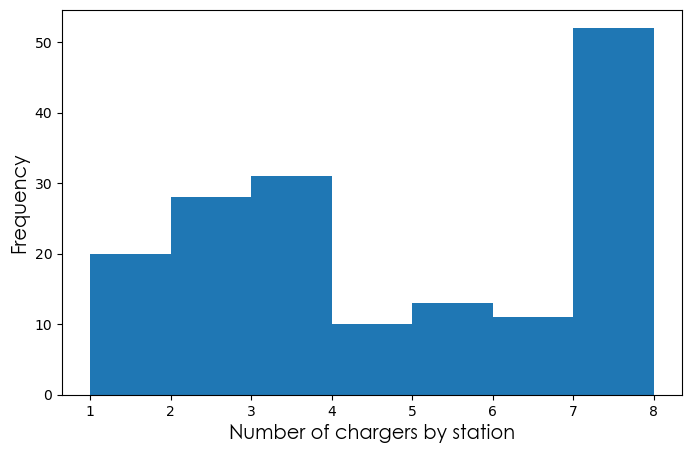

In [6]:
print(f"Total number of chargers: {sum(number_of_chargers.values())}")
print(f"Number of stations without chargers: {600-len(number_of_chargers)}")
for sc in range(25):
    print(f"\tScenario {sc} number of unassigned vehicles: {len(K_prime[sc])}")

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))

ax.hist(number_of_chargers.values(),bins=list(range(1,9)))

ax.set_xlabel("Number of chargers by station",fontsize=14,fontname="Century Gothic")
ax.set_ylabel("Frequency",fontsize=14,fontname="Century Gothic")

